In [1]:
library("IBMPopSim")
library("ggplot2")
library("Rcpp")
library(dplyr)
library(gridExtra)
library(ggExtra)


Attaching package: ‘IBMPopSim’


The following object is masked from ‘package:stats’:

    stepfun



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Generate initial population
N <- 10000  # Number of individuals in the initial population

In [3]:
# xb - xd is distributed uniformly on -10 ,10
xd <- runif(N,0,10)
pop_init <- data.frame(
  "birth" = rep(0,N), 
  "death" = as.double(NA),
  "Lansing" = rep(c(FALSE,FALSE),N/2),
    "ib"=1,
    "i_d"=1,
    "xb"= 10-xd, 
    "xd" =  xd, 
    "lignee"=1:N
)
get_characteristics(pop_init)


Lansing       ib      i_d       xb       xd   lignee 
  "bool" "double" "double" "double" "double"    "int"

In [4]:
head(pop_init)
#plot.ecdf(pop_init$xb-pop_init$xd)

,birth,death,Lansing,ib,i_d,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,NA,FALSE,1,1,4.802426,5.197574,1
2,0,NA,FALSE,1,1,7.974083,2.025917,2
3,0,NA,FALSE,1,1,7.307065,2.692935,3
4,0,NA,FALSE,1,1,1.570185,8.429815,4
5,0,NA,FALSE,1,1,6.555105,3.444895,5
6,0,NA,FALSE,1,1,4.485174,5.514826,6


In [5]:
# Events and model creation
 # There are 2 possible events :

# - Birth (with or without mutation)
# - Death

# Each event is characterized by its intensity and  kernel code, described below.

## Birth event with individual intensity

### Parameters



In [6]:
params_birth <- list("p"=0.1 , "var_mut"=0.05)

In [7]:
birth_event <- mk_event_individual( type = "birth",
  intensity_code = ' if (age(I,t) < I.xb)
                        result = I.ib; 
                    else 
                        result =0;',  # each individual  I can give birth at rate ib if its age is less than xb
  kernel_code = 'if (CUnif() < p){
                     newI.xb = max(0., CNorm(I.xb, var_mut));
                     newI.ib = max(0., CNorm(I.ib, var_mut));
                     newI.i_d = max(0., CNorm(I.i_d, var_mut));}
                 else{
                     newI.xb = I.xb;
                     newI.ib = I.ib;
                     newI.i_d = I.i_d;}
                if (I.Lansing & (age(I,t)> I.xd) & (age(I,t)<I.xb))
                     newI.xd =0;
                 else{
                    if (CUnif()<p)
                        newI.xd =max(0., CNorm(I.xd, var_mut));
                     else 
                        newI.xd =I.xd;}
                 newI.Lansing =I.Lansing;
                 newI.lignee =I.lignee;') 
# An individual I can give birth to an individual newI. The kernel code defines characteristics of individual newI
# Attention la manière dont est calculée le trait après mutation est un peu différente du code du Tristan

In [8]:
## Death event 
### parameters
params_death <- list("compet"= 0.0009)

In [9]:
## Deaths due to interactions
death_event1 <- mk_event_interaction(name='death1',
  type = "death",
  interaction_code = "result = compet;" 
)

In [10]:
## Deaths due to aging 
death_event2 <- mk_event_individual(name='death2', type="death",
                  intensity_code = ' if (age(I,t)>I.xd) result= I.i_d; 
                                     else result =0;')

In [11]:
# Model creation 
model <- mk_model(
  characteristics = get_characteristics(pop_init),
  events = list(birth_event, death_event1, death_event2),
  parameters = c(params_birth, params_death)

)
summary(model)

Events:
#1: individual event of type birth
#2: interaction event of type death
#3: individual event of type death
--------------------------------------- 
Individual description:
names:  birth death Lansing ib i_d xb xd lignee 
R types:  double double logical double double double double integer 
C types:  double double bool double double double double int
--------------------------------------- 
R parameters available in C++ code:
names:  p var_mut compet 
R types:  double double double 
C types:  double double double

In [12]:
## Bounds for birth and death rates 
birth_intensity_max <- 10
interaction_fun_max <- params_death$compet
death2_max <- 10

In [13]:
T = 100 # Simulation end time 

sim_out <- popsim(model = model,
  population = pop_init,
  events_bounds = c('birth'=birth_intensity_max, 'death1'=interaction_fun_max,'death2'= death2_max),
  parameters = c(params_birth, params_death),
  time = T)

Simulation on  [0, 100] 

In [14]:
# Simulation with different parameters

#The model can be simulated with different parameters without being recompiled.


In [15]:
#sim_out$logs["duration_main_algorithm"]
#sim_out$logs

In [16]:
# Outputs

In [17]:
str(sim_out$population)

'data.frame':	312364 obs. of  8 variables:
 $ birth  : num  97 97 97 97.3 97.4 ...
 $ death  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Lansing: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ ib     : num  2.4 2.39 2.6 2.48 2.43 ...
 $ i_d    : num  0.55 0.569 0.672 0.424 1.12 ...
 $ xb     : num  5.24 5.34 5.38 5.29 5.31 ...
 $ xd     : num  4.72 4.98 5.02 4.87 5.12 ...
 $ lignee : int  2740 2740 2740 2740 2740 2740 2740 2740 2740 2740 ...


In [18]:
pop_out <- sim_out$population
head(pop_out)
tail(pop_out)

,birth,death,Lansing,ib,i_d,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,96.96143,NA,FALSE,2.404278,0.5500211,5.242355,4.716639,2740
2,97.03263,NA,FALSE,2.391367,0.5694411,5.337469,4.975099,2740
3,97.04845,NA,FALSE,2.596090,0.6722603,5.376622,5.016792,2740
4,97.27085,NA,FALSE,2.482827,0.4243677,5.287262,4.872485,2740
5,97.40274,NA,FALSE,2.426873,1.1198451,5.312495,5.117029,2740
6,97.43857,NA,FALSE,2.461583,0.5582757,5.461465,5.046899,2740


,birth,death,Lansing,ib,i_d,xb,xd,lignee
,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
312359,99.92637,99.99847,FALSE,2.570798,0.7446648,5.396958,5.016792,2740
312360,99.93922,99.99721,FALSE,2.517804,0.7099719,5.532422,5.165824,2740
312361,99.96801,99.99725,FALSE,2.497503,0.4333539,5.342576,4.866530,2740
312362,99.97402,99.99672,FALSE,2.590690,0.6757089,5.580944,5.032637,2740
312363,99.98880,99.99941,FALSE,2.514279,0.5992418,5.466746,5.134916,2740
312364,99.99423,99.99768,FALSE,2.643949,0.8334075,5.637750,5.100082,2740


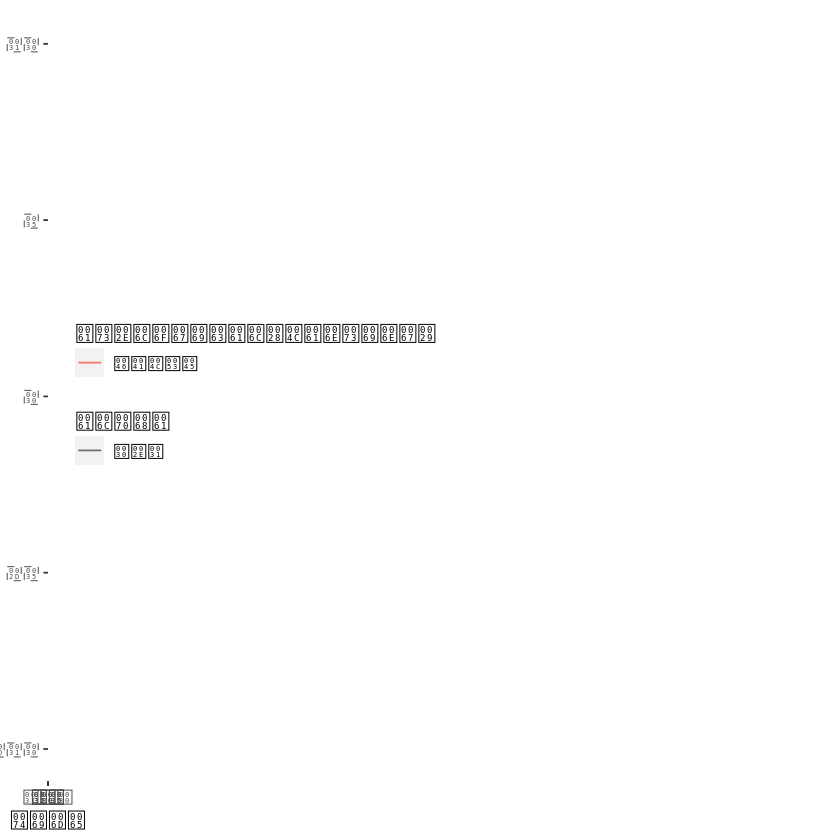

In [20]:
#options(repr.plot.width=15, repr.plot.height=15)
xbxd_evol_for_publi <- ggplot(pop_out %>% sample_n(10000), aes(color=as.logical(Lansing), alpha = 0.1)) + 
  geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.1) , na.rm=TRUE)+
  xlab("Time") +
  ylab("xb-xd") + 
  geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
  geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
  labs(x='time',y='xb - xd')

xbxd_evol_for_publi

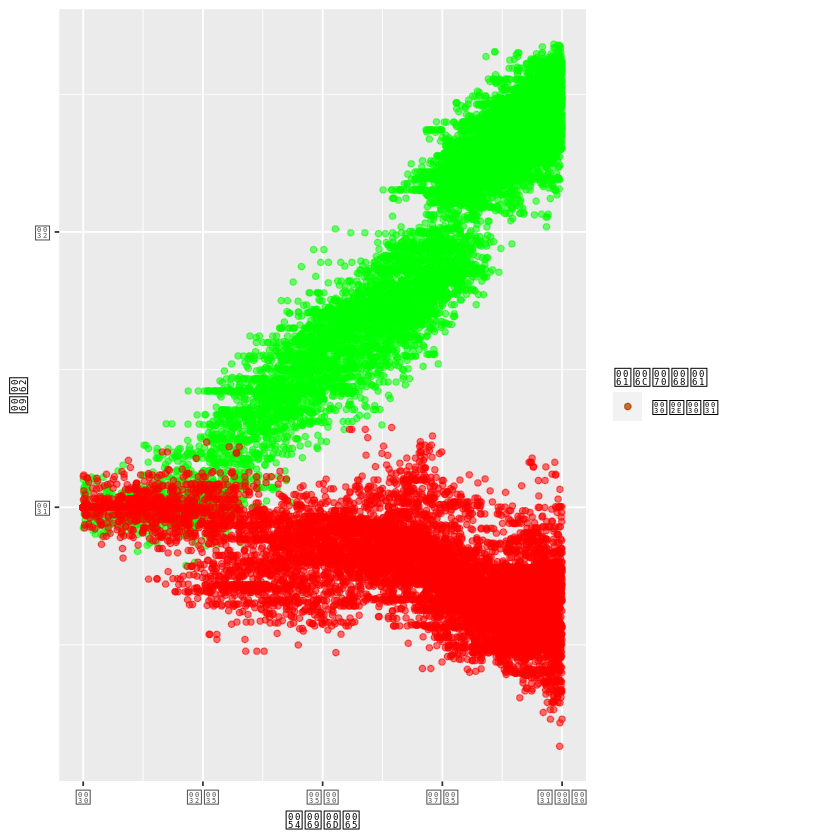

In [30]:
#options(repr.plot.width=15, repr.plot.height=15)
ibid_evol_for_publi <- ggplot(pop_out %>% sample_n(10000), aes(x=birth)) + 
  geom_point(aes(y=ib, alpha = 0.01) , na.rm=TRUE, colour='green')+
  geom_point(aes(y=i_d, alpha = 0.01) , na.rm=TRUE, colour='red')+
  xlab("Time") 
  #ylab("xb-xd") + 
  #theme(legend.position="none")+
  #theme(axis.text=element_text(size=12),
  #      axis.title=element_text(size=14,face="bold"))

ibid_evol_for_publi

In [22]:
# Create a sampled dataset 
sample_data <- pop_out %>% sample_n(10000)

# Generate the ggplot
p0 <- ggplot(sample_data, aes(x = birth, alpha = 0.1)) + 
  geom_point(aes(y = ib, color = 'IB'), na.rm = TRUE) +
  geom_point(aes(y = i_d, color = 'ID'), na.rm = TRUE) +
  scale_color_manual(
    name = "Groups",
    values = c("IB" = "green", "ID" = "red")
  ) +
  scale_alpha(guide = 'none') +  # Hide alpha legend
  labs(
    x = "Time",
    y = "Value",
    title = "Your Plot Title",
    subtitle = "Your Plot Subtitle",
    caption = "Your Caption"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    legend.position = "bottom",
    panel.grid.major = element_line(color = "grey90")
  )

In [23]:
#options(repr.plot.width=15, repr.plot.height=15)
p1<-ggplot(pop_out %>% sample_n(10000)) + 
  geom_point(aes(x=xb,y=ib, alpha = 0.1, colour=birth))+ theme(legend.position = "none") 
p1<-ggMarginal(p1,type = "histogram", xparams = list(binwidth = 0.1)) 
p2<-ggplot(pop_out %>% sample_n(10000)) + 
  geom_point(aes(x=xd,y=i_d, alpha = 0.1, colour=birth))+ theme(legend.position = "none") 
p2<-ggMarginal(p2,type = "histogram", xparams = list(binwidth = 0.1))

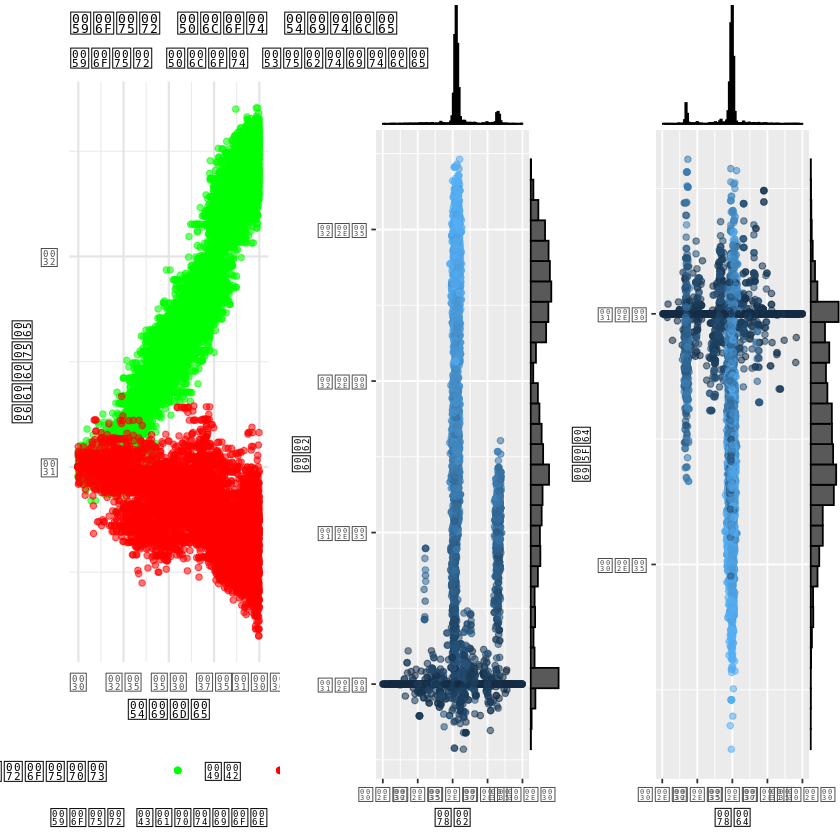

In [ ]:
grid.arrange(p0, p1, p2, ncol=3)

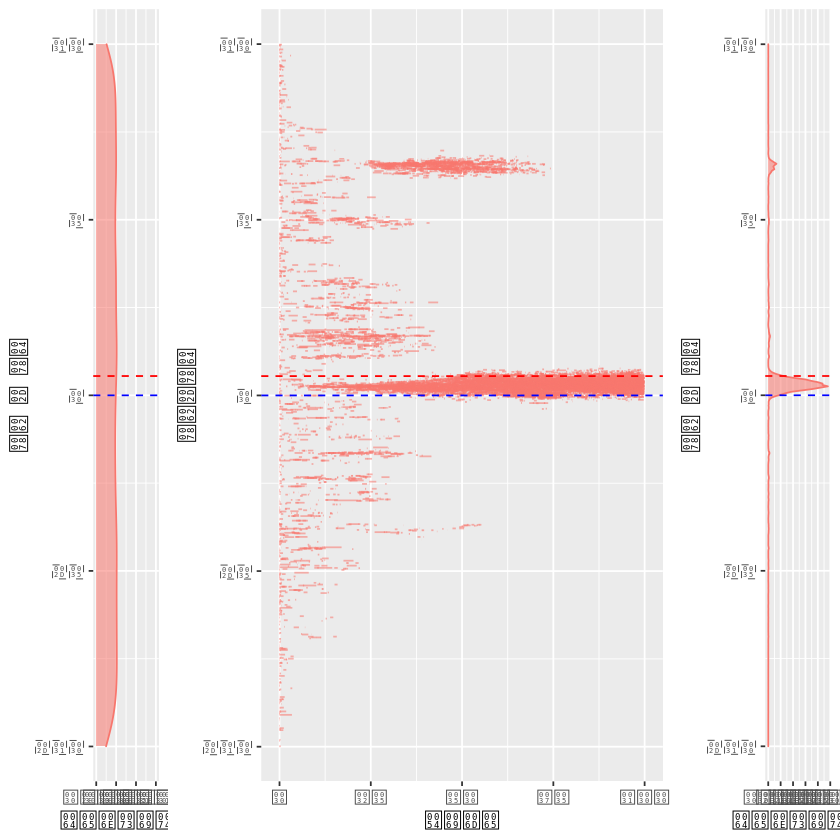

In [25]:
t0density <-  ggplot(pop_out %>% filter(birth==0), aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                ylim(0,0.15) + 
                coord_flip() +
                theme(legend.position="none")

soldensity <- ggplot(pop_out, aes(x=xb-xd, color=Lansing, fill=Lansing, height=..scaled.., alpha = 0.1)) + 
                geom_density() + 
                geom_vline(xintercept = 0, color = "blue", linetype="dashed")  +
                geom_vline(xintercept = log(3)/2, color = "red", linetype="dashed") +
                coord_flip() +
                xlim(-10,10) +
                theme(legend.position="none")

xbxd_evol <- ggplot(pop_out  %>% sample_n(20000), aes(color=as.logical(Lansing))) + 
                geom_segment(aes(x=birth, xend=death, y=xb-xd, yend=xb-xd, alpha =0.5) , na.rm=TRUE)+
                xlab("Time") +
                ylab("xb-xd") + 
                geom_hline(yintercept=log(3)/2, color = "red", linetype="dashed") +
                geom_hline(yintercept = 0, color = "blue", linetype="dashed") +
                theme(legend.position="none")

p = grid.arrange(t0density, xbxd_evol, soldensity, ncol=3, nrow = 1, widths=c(2,6,2))

In [26]:
#calculation of Malthusian parameters (Newton's method)
deriv_2 <- function(f, x, y, dx){
  return((f(x+dx, y)-f(x, y))/dx)
}
deriv_3 <- function(f, x, y, z, dx){
  return((f(x+dx, y, z)-f(x, y, z))/dx)
}
F <- function(a, b){
  u = 0
  if(a == 0){u = b - 1}
  else{u = ((1/a)*(1-exp(-a*b)))-1}
  return(u)
}
H <- function(a, b, d){
  u = 0
  if(a == 0){ u = d - exp(d-b)}
  else{u = ((1-exp(-a*d))/a) + (exp(d)/(1+a))*(exp(-d*(1+a))-exp(-b*(1+a)))-1}
  return(u)
}
G <- function(a, d){
  u = 0
  if(a == 0){u = d - 1}
  else{u = ((1/a)*(1-exp(-a*d)))-1}
  return(u)
}
malthus_nl <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b)/deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while((abs(H(v,b,d))>epsilon)){
      v = v - (H(v, b, d)/deriv_3(H, v, b, d, delta))
    }
    return(v)
  }
}
malthus_l <- function(b, d, x_0, epsilon, delta){
  if(b<=d){
    u = x_0
    while(abs(F(u, b))>epsilon){
      u = u - (F(u, b) / deriv_2(F, u, b, delta))
    }
    return(u)
  } else {
    v = x_0
    while(abs(G(v, d))>epsilon){
      v = v - (G(v, d) / deriv_2(G, v, d, delta))
    }
    return(v)
  }
}
x_0 = 0.5; epsilon = 0.00001; delta = 0.000001; u = 0

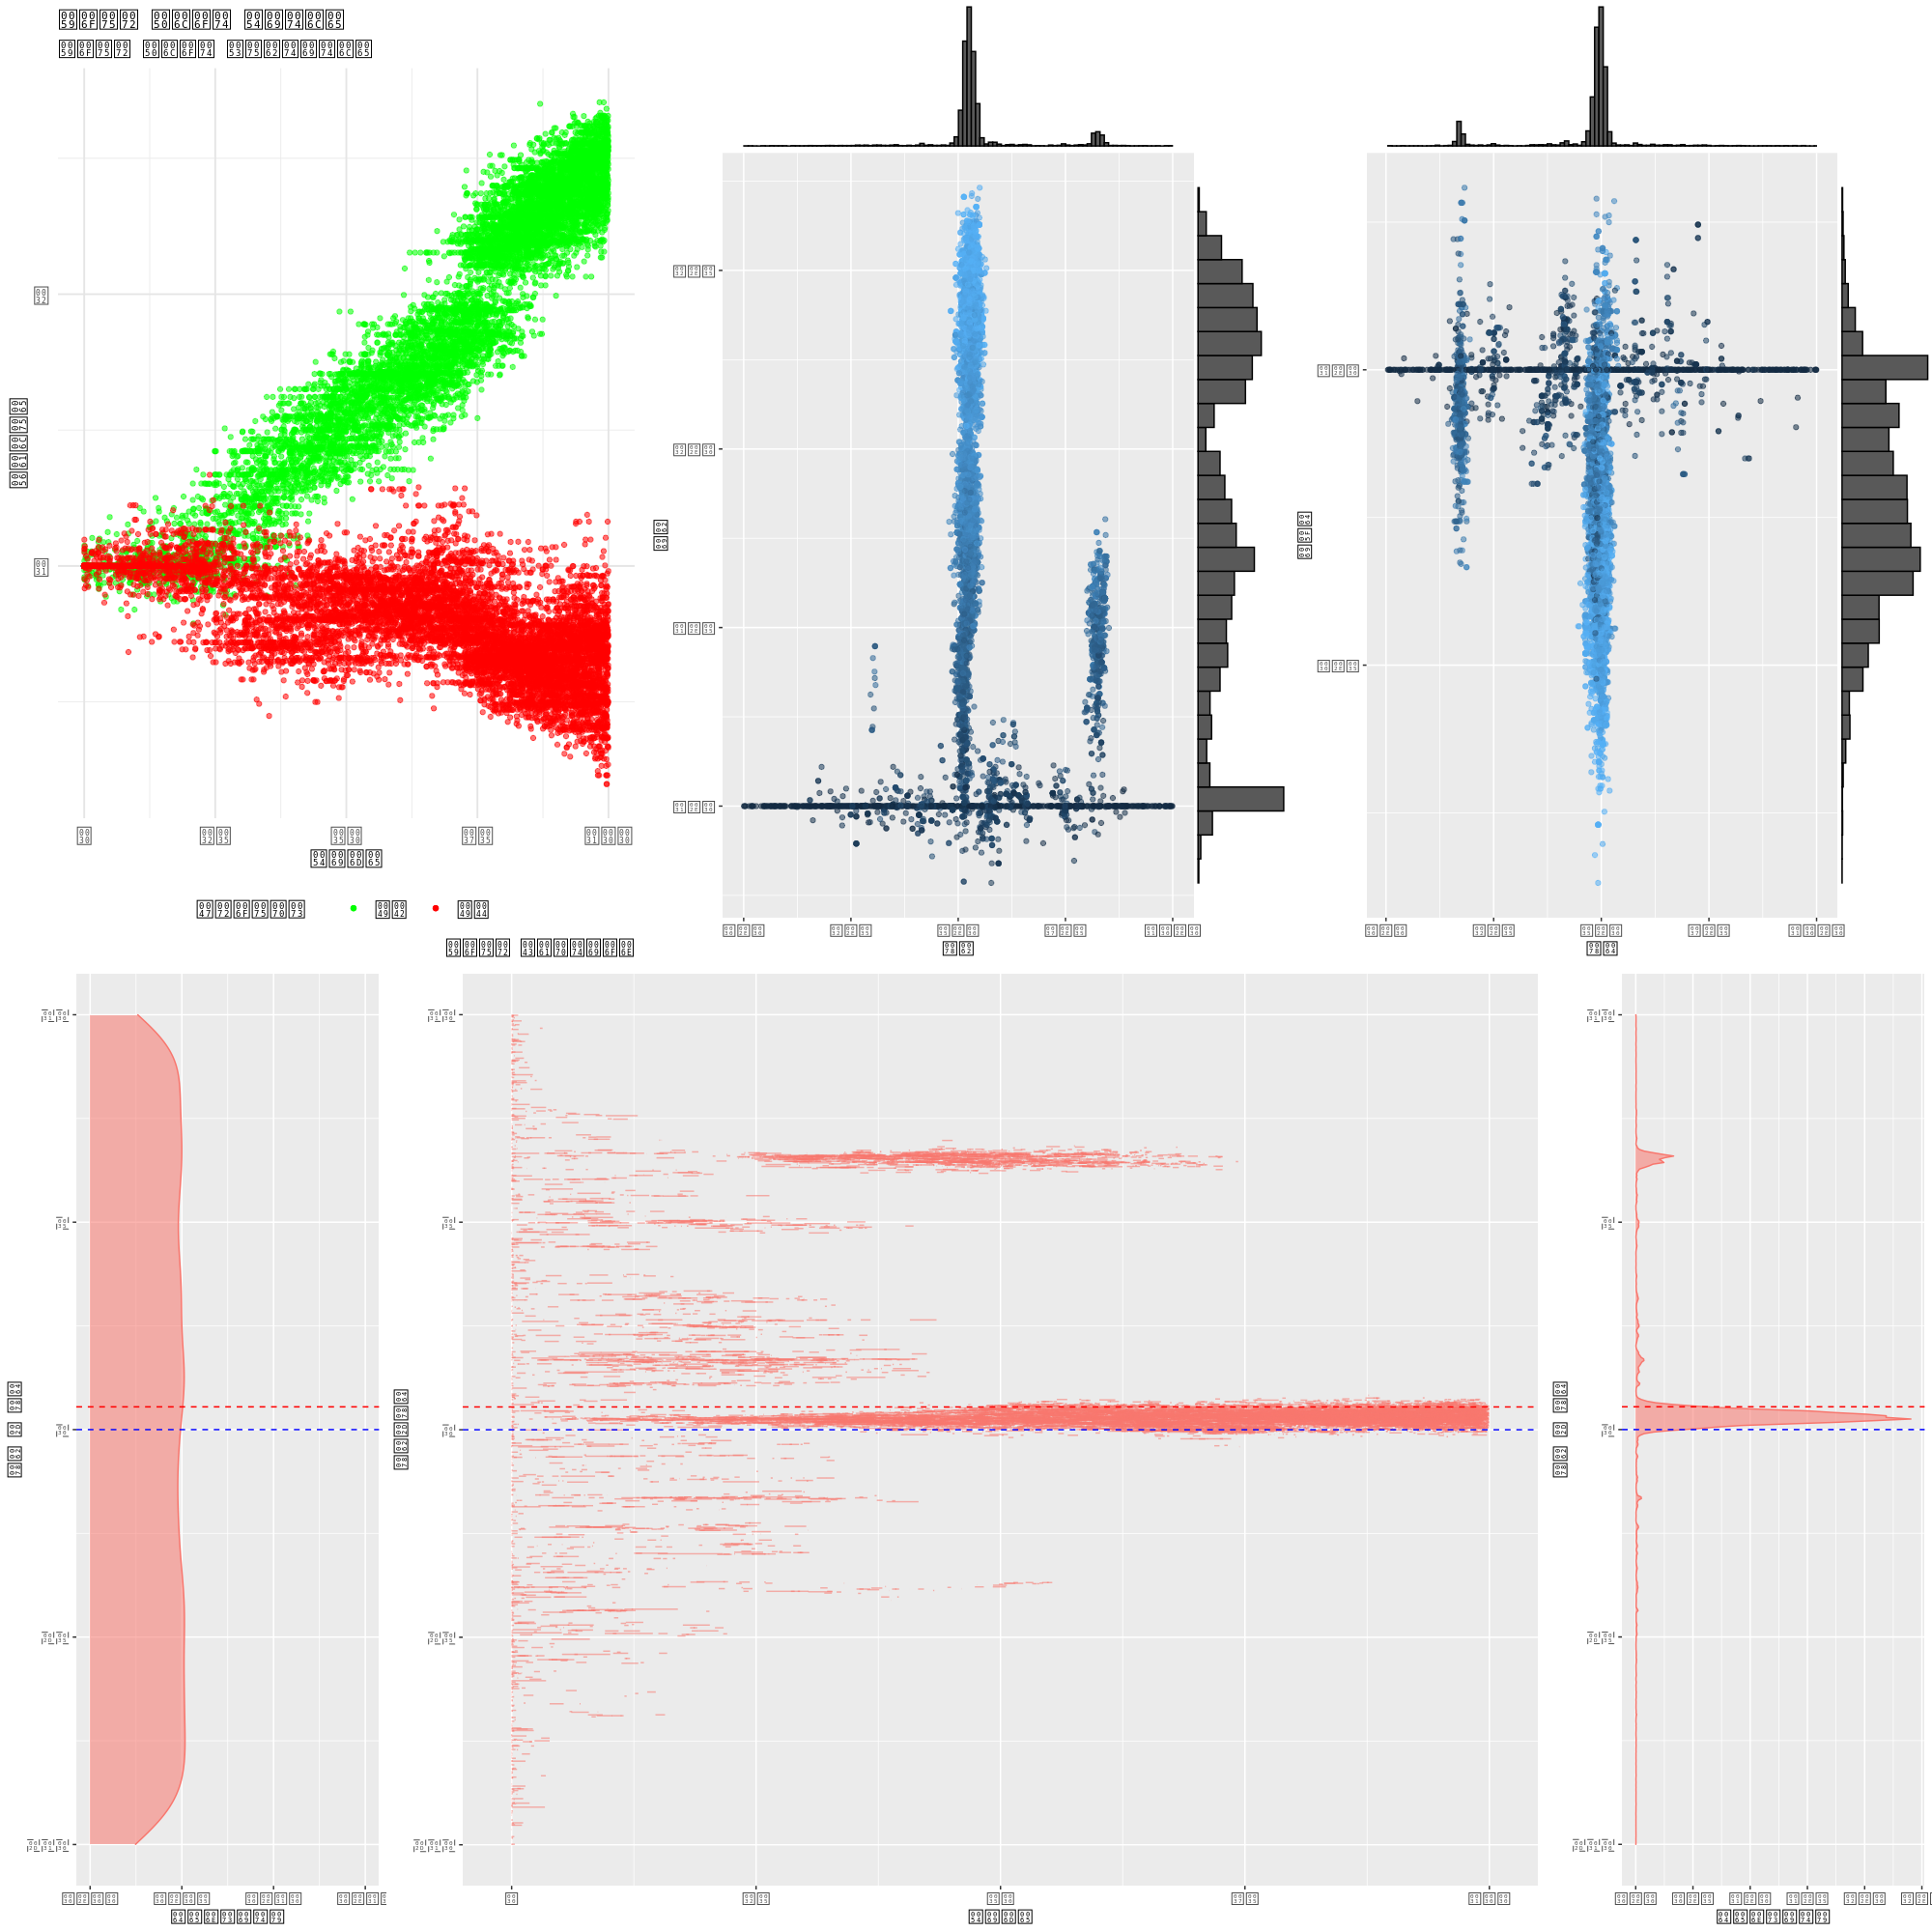

In [33]:
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 100)
layout_matrix <- rbind(
  c(1, 2, 3),
  c(4, 4, 4))
grid.arrange(p0, p1, p2, p, layout_matrix=layout_matrix)

In [27]:
t=seq(0, round(max(pop_out$birth)))
pop_out_mod <- pop_out %>% mutate(Malthus = ifelse(Lansing==TRUE,malthus_l(xb, xd, x_0, epsilon, delta),malthus_nl(xb, xd, x_0, epsilon, delta)))
fun = function(t){
    pop_t <- population_alive(pop_out_mod, t) 
    pop_t_L <- pop_t %>% filter(Lansing)
    pop_t_nL <- pop_t %>% filter(!Lansing)
    rbind(t, pop_t_L %>% count(), pop_t_L[,7] %>% median(na.rm=TRUE), pop_t_nL%>% count(), pop_t_nL[,7]  %>% median(na.rm=TRUE))
} 
surv_table <- as.data.frame(t(matrix(unlist(cbind(lapply(t, fun))),5)))
colnames(surv_table) <- c("time", "Lansing", "mean_Malthus_L","nonLansing", "mean_Malthus_nL")
max_pop <- surv_table %>% filter(time > 5) %>% select(Lansing, nonLansing) %>% max()
max_pop
head(surv_table)

Warning message in if (b <= d) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while ((abs(H(v, b, d)) > epsilon)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while ((abs(H(v, b, d)) > epsilon)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (a == 0) {:
“the condition has length > 1 and only the first element will be used”
Warning message in while ((abs(H(v, b, d)) > epsilon)) {:
“the condition has length > 1 and only the first eleme

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=Lansing), color = "#00BDD0" )+
  geom_line(aes(x=time, y=nonLansing), color = "#F8766D" ) +
  ylim(0, max_pop)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))

In [ ]:
 ggplot(surv_table) + 
  geom_line(aes(x=time, y=mean_Malthus_L), color = "#00BDD0" )+
  geom_line(aes(x=time, y=mean_Malthus_nL), color = "#F8766D" ) +
  #ylim(0, 1)+
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))